# Networkx 3D

An idea to make cross-eyed network models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [171]:
def make_network(n=10):
    """Barabasi network."""
    gdict = {}
    deg = np.zeros(n)
    for i in range(n):
        gdict[i] = []
        deg[i] += 1
        if i==1:
            gdict[i].append(0)
            gdict[0].append(1)
        elif i>1:
            friends = np.random.choice(range(0,i), 2, replace=False, p=deg[:i]/np.sum(deg[:i]))
            for j in friends:
                gdict[i].append(j)
                gdict[j].append(i)
                deg[j] += 1
    return gdict

make_network(4)

{0: [1, 2], 1: [0, 2, 3], 2: [0, 1, 3], 3: [1, 2]}

In [172]:
def dict_to_nx(gdict):
    """Translate graph dictionary to a networkx object."""
    g = nx.Graph()
    for key,val in gdict.items():
        g.add_node(key)
    for key,val in gdict.items():
        for friend in val:
            g.add_edge(key,friend)
    return g

g = dict_to_nx(make_network(10))

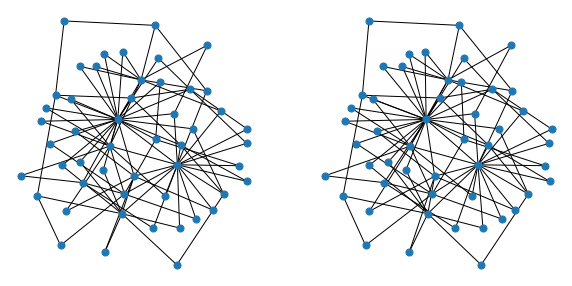

In [181]:
def refine(g, pos):
    """Infer possible z from x and y for a graph layout, using force-based approach."""
    MAX_ITERATIONS = 100
    ALPHA = 0.2             # Learning speed (integration constant)
    DECAY = 0.1             # Momentum decay (drag)
    
    def _dist(xyz,i,j):
        return np.sqrt(np.square(xyz[i][0]-xyz[j][0])+
                       np.square(xyz[i][1]-xyz[j][1])+np.square(xyz[i][2]-xyz[j][2]))    
    n = len(pos)
    xyz = np.zeros((n,3))
    v = np.zeros(n)
    for i in range(n):
        xyz[i,:] = [pos[i][0], pos[i][1], 0]
    #best_d = np.mean([_dist(xyz,i,j) for i in range(1,n) for j in range(i)])
    #print(best_d)
    best_d = 1 # Target distance. Seems that these layouts are normalized, so just := 1
    xyz[:,2] = np.random.uniform(size=n)
    for t in range(MAX_ITERATIONS):
        for i in range(1,n):
            v[i] *= 1-DECAY
            xyz[i,2] += v[i]*ALPHA
            for j in range(i):
                d = _dist(xyz, i, j)
                force = (d-best_d)/d*(xyz[i,2]-xyz[j,2]) # force j towards i
                v[i] += -force*ALPHA
                v[j] += force*ALPHA
    if False: # Lil troubleshooter to check if z axis even makes sense
        plt.figure(figsize=(10,5))
        plt.subplot(111)
        nx.draw(g, pos={i:[xyz[i,0], xyz[i,2]] for i in range(n)}, node_size=50)
    return xyz

def gplot(g):
    """3D graph plot"""
    pos=nx.kamada_kawai_layout(g)
    xyz = refine(g, pos)
    fig = plt.figure(figsize=(10,5))
    plt.subplot(121)
    nx.draw(g, pos={i:[xyz[i,0], xyz[i,1]] for i in range(len(g))}, node_size=50) 
    plt.subplot(122)
    nx.draw(g, pos={i:[xyz[i,0]+xyz[i,2]*0.05, xyz[i,1]] for i in range(len(g))}, 
            node_size=50) # node_color=xyz[:,2], cmap = 'OrRd'?
    fig.patch.set_facecolor('white')
    
g = dict_to_nx(make_network(50))
gplot(g)